## Implementação prática de um algoritmo de Regressão Logística
### Fazendo uso da função de ativação sigmoidal (logistic)

$$logistic= \frac{1}{(1 + e^{-z})}$$

Tal que $z$ será:

$$ z = (a_1 \cdot x_1 + a_2 \cdot x_2 + ... + a_n \cdot x_n) + b $$

In [510]:
#Importação das bibliotecas necessárias
import numpy as np
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz as sv
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

### Definição do modelo e seus métodos:
* Precisão
* Acurácia
* Acurácia Balanceada
* Teste (Prediction)
* Treino (Fit)

In [511]:
class BinaryLogisticRegressor:
    
    def __init__(self, learning_rate=0.001, n_iterations=10000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        
    #Definicao da função de ativação       
    def _sigmoid(self, x):
        x = np.array(x)
        x=x.reshape(-1,1)
        x = x.astype(float)
        #Função sigmoide
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Inicialização dos pesos
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradiente descendente
        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)
            y_predicted = y_predicted.astype(float)
            
            # Calculo do gradiente
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            # Atualização dos pesos
            self.weights = self.weights.reshape(-1,1)
            self.weights = self.weights.astype(float)
            dw= dw.reshape(-1,1)
            dw = dw.astype(float)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        #Aplicacao da função de ativação para retornar a classe predita
        y_predicted = self._sigmoid(linear_model)
        #Classificação da classe predita de forma binária (0 ou 1)
        y_predicted_cls = [1 if i < 0.42 else 0 for i in y_predicted]
        return y_predicted_cls
    

In [512]:
#Definindo um classe para escalonamento dos dados 
#Para os seguintes metodos: MinMax, Standard e Normal
class Scaler:
        
        def __init__(self, method):
            self.method = method
        
        def fit(self, X):
            if self.method == 'minmax':
                self.min = np.min(X, axis=0)
                self.max = np.max(X, axis=0)
            elif self.method == 'std':
                self.mean = np.mean(X, axis=0)
                self.std = np.std(X, axis=0)
            elif self.method == 'normal':
                self.mean = np.mean(X, axis=0)
                self.std = np.std(X, axis=0)
            else:
                raise Exception('Método inválido ou não implementado')
        
        def transform(self, X):
            if self.method == 'minmax':
                return (X - self.min) / (self.max - self.min)
            elif self.method == 'std':
                return (X - self.mean) / self.std
            elif self.method == 'normal':
                return (X - self.mean) / self.std
            else:
                raise Exception('Método inválido ou não implementado')


In [513]:
class Metrics:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.positive= np.sum(y_true == 1)
        self.negative= np.sum(y_true == 0)
        
        false_positive = 0
        false_negative = 0
        true_positives = 0
        true_negatives = 0
        
        for i in range (len(y_true)):
            if y_pred[i] == 1 and y_true[i] == 1:
                true_positives += 1
            elif y_pred[i] == 1 and y_true[i] == 0:
                false_positive += 1
            elif y_pred[i] == 0 and y_true[i] == 1:
                false_negative += 1
            elif y_pred[i] == 0 and y_true[i] == 0:
                true_negatives += 1
        
        self.false_positive = false_positive
        self.false_negative = false_negative
        self.true_positives = true_positives
        self.true_negatives = true_negatives
        
        
        
    def accuracy(self):
        accuracy = np.sum(self.y_true == self.y_pred) / len(self.y_true)
        return accuracy
    
    def balanced_accuracy(self):
        balanced_accuracy = (self.true_positives / self.positive + self.true_negatives / self.negative) / 2
        return balanced_accuracy
    
    def sensitivity(self):
        sensitivity = self.true_positives / self.positive
        return sensitivity
    
    def specificity(self):
        specificity = self.true_negatives / self.negative
        return specificity

            

In [514]:
#Implementaçao de classe para separar os dados em treino e teste dado um modelo de separação
#Kfold, TrainTestSplit 

class Split:
    def __init__(self, method):
        self.method = method
    
    def kfold(self, X, y, k):
        n_samples = X.shape[0]
        n_samples_per_fold = n_samples // k
        X_folds = []
        y_folds = []
        for i in range(k):
            X_folds.append(X[i * n_samples_per_fold : (i + 1) * n_samples_per_fold])
            y_folds.append(y[i * n_samples_per_fold : (i + 1) * n_samples_per_fold])
        return X_folds, y_folds

    def train_test_split(self, X, y, test_size):
        n_samples = X.shape[0]
        n_samples_test = int(n_samples * test_size)
        n_samples_train = n_samples - n_samples_test
        X_train = X[:n_samples_train]
        y_train = y[:n_samples_train]
        X_test = X[n_samples_train:]
        y_test = y[n_samples_train:]
        return X_train, X_test, y_train, y_test

In [515]:
#Importando o dataset
zf = zipfile.ZipFile('archive.zip')
data = pd.read_csv(zf.open('data.csv'))

In [541]:
#Visualizando as features presentes no modelo
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [517]:
#Visualizando as features presentes no modelo
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [518]:
#Removendo dados desnecessários
data.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [519]:
#Embaralhando os dados
data = data.sample(frac=1)

In [520]:
fig = px.scatter_matrix(data, dimensions=data.columns[0:18])#,color=data_train.columns[8])
fig.update_layout(
    autosize=True,
    width=2000,
    height=2000,
)
fig.update_yaxes(automargin=True)

fig.show()


In [521]:
data.shape

(569, 31)

In [522]:
#Embaralhando os dados
data = data.sample(frac=1)

In [523]:
#Selecionando as features que serão utilizadas no modelo
X = data.values[:, 1:3]
print(X.shape)
y = data.values[:, 0]

(569, 2)


In [524]:
#Visualizando as classes presentes no dataset
np.unique(y)

array(['B', 'M'], dtype=object)

In [525]:
#Convertendo as classes para valores binários
y = np.where(y == 'M', 1, 0)

In [526]:
#Verificando a conversão
np.unique(y)

array([0, 1])

In [539]:
#Convertendo os dados para vetores do tipo np.array
X = np.array(X)
print(X.shape)
y = np.array(y)
y=y.reshape(-1,1)
print(y.shape)

(569, 2)
(569, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

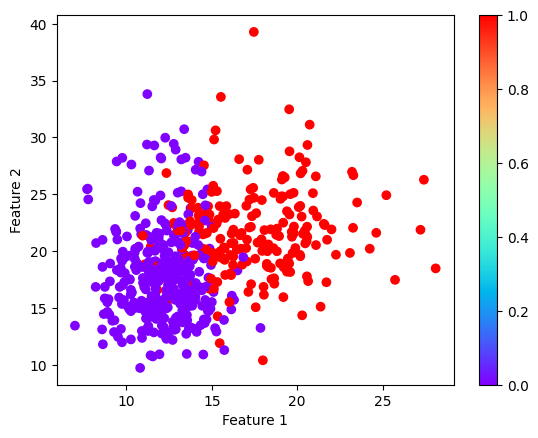

In [528]:
#Visualizando os dados de forma gráfica

fig, ax = plt.subplots()
sc=ax.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow') # Reshape y to a 1D array
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.colorbar(sc)
plt.show


In [529]:
#Instanciando o classificador e o escalonador
clf = BinaryLogisticRegressor()
sc= Scaler('minmax')

In [530]:
#Escalonando os dados
sc.fit(X)
X = sc.transform(X)
print(min(X[:,0]), max(X[:,0]), min(X[:,1]), max(X[:,1]))

0.0 1.0 0.0 1.0


In [531]:
#Instanciando o objeto para separação dos dados
#Utilizando o TrainTestSplit

split = Split('train_test_split')

#Separando os dados em treino e teste com 20% dos dados para teste
X_train, X_test, y_train, y_test = split.train_test_split(X, y, 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_test)



(456, 2) (113, 2) (456, 1) (113, 1)
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]]


In [532]:
#Treinando o modelo
clf.fit(X_train, y_train)

In [533]:
#Realizando a predição
y_pred = clf.predict(X_test)
y_pred = np.array(y_pred)



In [534]:
m=Metrics(y_test, y_pred)

print('Acurácia: ', m.accuracy())
print('Acurácia Balanceada: ', m.balanced_accuracy())
print('Sensibilidade: ', m.sensitivity())
print('Especificidade: ', m.specificity())
print('Falso Positivo: ', m.false_positive)
print('Falso Negativo: ', m.false_negative)
print('Verdadeiro Positivo: ', m.true_positives)
print('Verdadeiro Negativo: ', m.true_negatives)
print('Positivo: ', m.positive)
print('Negativo: ', m.negative)



Acurácia:  45.6283185840708
Acurácia Balanceada:  0.37209302325581395
Sensibilidade:  0.7441860465116279
Especificidade:  0.0
Falso Positivo:  70
Falso Negativo:  11
Verdadeiro Positivo:  32
Verdadeiro Negativo:  0
Positivo:  43
Negativo:  70


In [537]:
def plot_decision_boundary(X, y, model):
    # Plot dos pontos de dados
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Cálculo da reta de decisão
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    y_predicted = model.predict(X_grid)
    decision_boundary = -model.weights[0]/model.weights[1] * X_grid[:,0] - model.bias/model.weights[1]
    decision_boundary = decision_boundary.reshape(xx.shape)
    plt.contourf(xx, yy, np.array(y_predicted).reshape(xx.shape), alpha=0.5)
    plt.contour(xx, yy, decision_boundary, colors='k')
    
    plt.show()

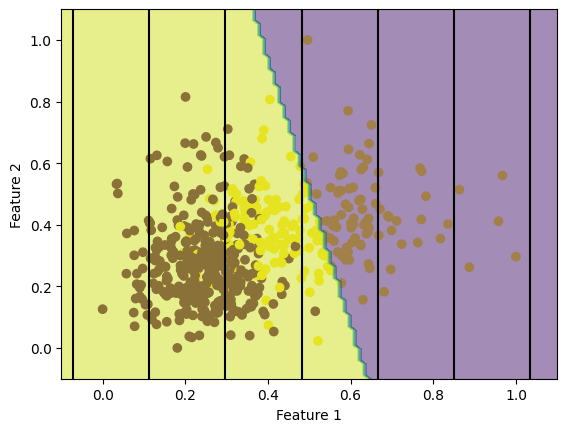

In [538]:
plot_decision_boundary(X, y, clf)